In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from sklearn.metrics import accuracy_score

In [ ]:
from dywpe.ablation.benchmark import PositionalEncodingBenchmark
from dywpe.ablation.complete_ablation import run_core_ablation_studies

Starting benchmark on 1 positional encodings...
Epochs per encoding: 50
Test set evaluation: ENABLED

Benchmarking: DYWPE
Epoch  2: Train Acc: 0.3734, Val Acc: 0.4145, Time: 0.89s
Epoch  4: Train Acc: 0.4260, Val Acc: 0.4490, Time: 0.91s
Epoch  6: Train Acc: 0.4667, Val Acc: 0.4285, Time: 1.30s
Epoch  8: Train Acc: 0.5021, Val Acc: 0.5312, Time: 0.98s
Epoch 10: Train Acc: 0.5099, Val Acc: 0.5329, Time: 1.03s
Epoch 12: Train Acc: 0.5271, Val Acc: 0.5567, Time: 0.93s
Epoch 14: Train Acc: 0.5403, Val Acc: 0.5436, Time: 1.02s
Epoch 16: Train Acc: 0.5654, Val Acc: 0.5428, Time: 0.93s
Epoch 18: Train Acc: 0.5715, Val Acc: 0.5625, Time: 0.96s
Epoch 20: Train Acc: 0.5761, Val Acc: 0.6003, Time: 0.91s
Epoch 22: Train Acc: 0.5905, Val Acc: 0.5962, Time: 1.04s
Epoch 24: Train Acc: 0.5876, Val Acc: 0.5855, Time: 0.92s
Epoch 26: Train Acc: 0.5938, Val Acc: 0.5962, Time: 1.04s
Epoch 28: Train Acc: 0.5933, Val Acc: 0.6176, Time: 1.19s
Epoch 30: Train Acc: 0.6106, Val Acc: 0.6086, Time: 0.96s
Epoch 32

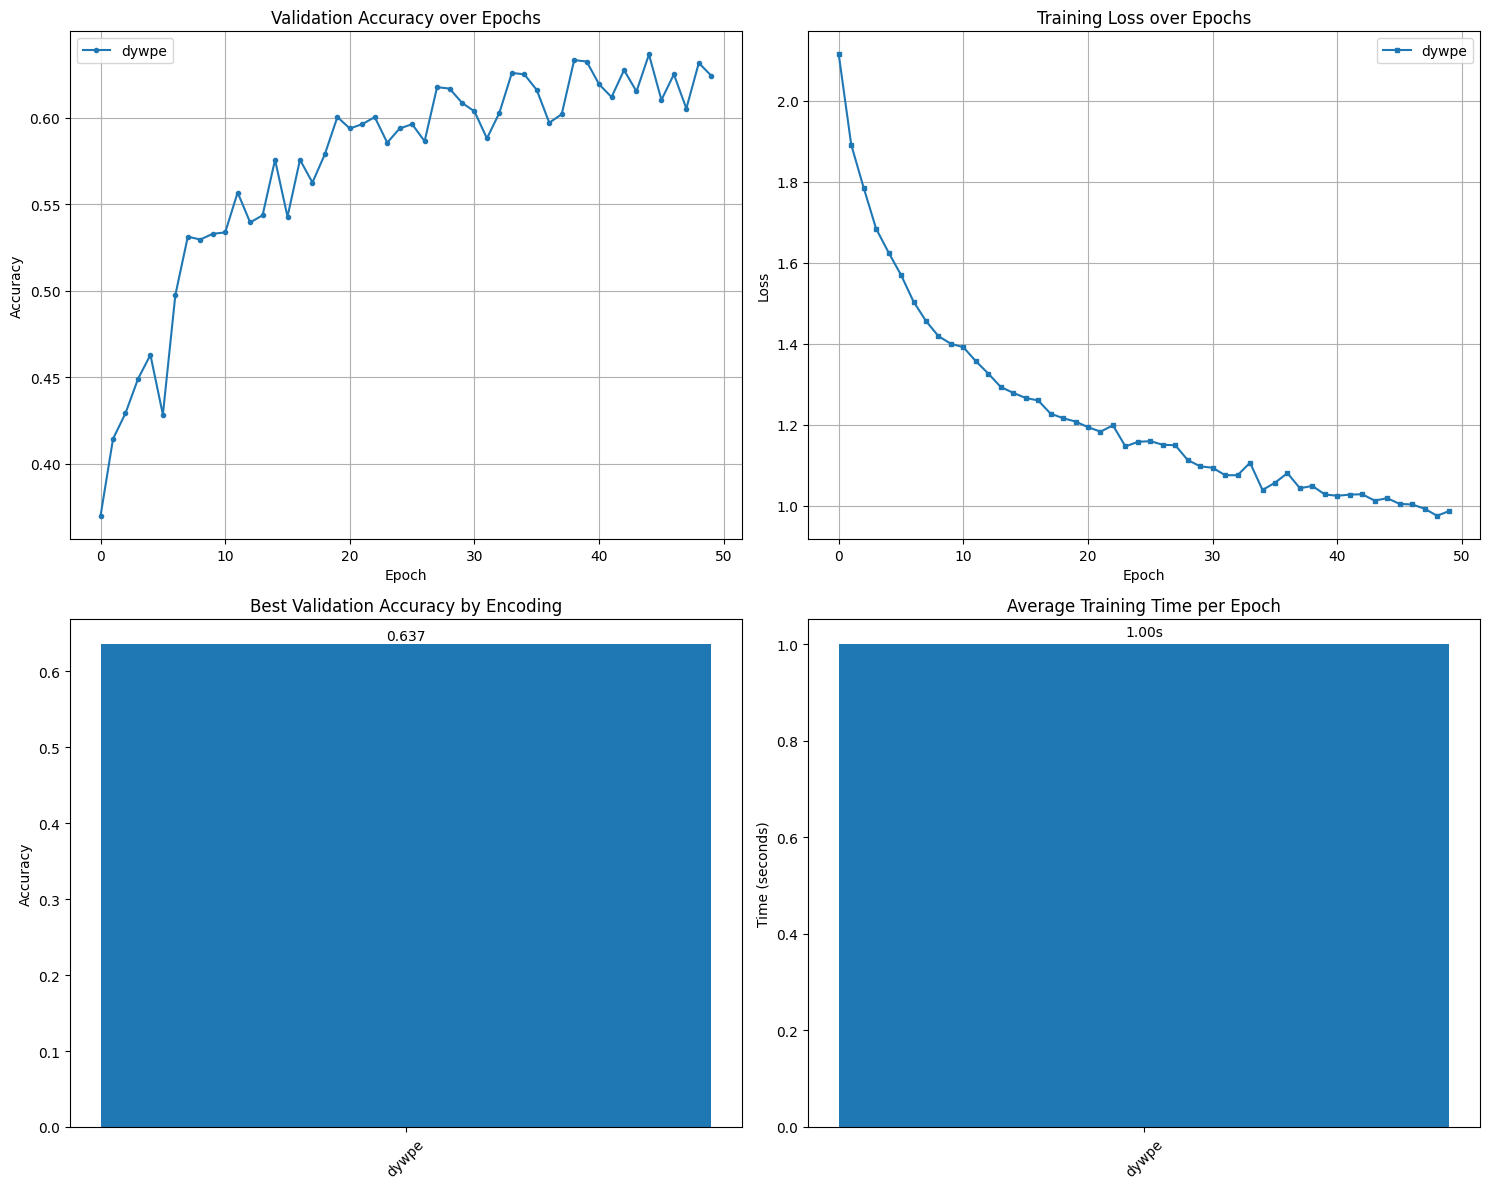

In [ ]:
# Initialize benchmark
benchmark = PositionalEncodingBenchmark()

model_params = {
    'input_timesteps': 36,
    'in_channels': 6,
    'patch_size': 8,
    'embedding_dim': 32,
    'num_transformer_layers': 4,
    'num_heads': 4,
    'dim_feedforward': 128,
    'dropout': 0.2,
    'num_classes': 14
}

# Option 1: Test only your top performers from validation results
models = benchmark.run_full_benchmark(
    model_params,
    train_loader_fixed,
    valid_loader_fixed,
    test_loader_fixed,
    encodings=['dywpe'],
    n_epochs= 50
)

# Option 2: Or test all methods (if you have time)
# models = benchmark.run_full_benchmark(
#     model_params, train_loader, valid_loader, test_loader,
#     n_epochs=15
# )

# Get comprehensive results with test performance
benchmark.print_summary()
benchmark.plot_comparison('final_results_with_test.png')

In [4]:
import os
import zipfile
import urllib.request
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.io import arff
import torch
from torch.utils.data import TensorDataset, DataLoader

# Directory where datasets will be downloaded and extracted
DATA_DIR = 'datasets'

# Ensure the dataset directory exists
os.makedirs(DATA_DIR, exist_ok=True)

def download_dataset(dataset_name, url):
    """
    Downloads and extracts a zip file containing the dataset.
    """
    zip_path = os.path.join(DATA_DIR, f"{dataset_name}.zip")
    extract_path = os.path.join(DATA_DIR, dataset_name)

    # Download the dataset
    print(f"Downloading {dataset_name} from {url}...")
    urllib.request.urlretrieve(url, zip_path)

    # Extract the zip file
    print(f"Extracting {dataset_name}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Remove the zip file after extraction
    os.remove(zip_path)
    print(f"Dataset {dataset_name} extracted to {extract_path}.")
    return extract_path

def load_arff_data(file_path):
    """
    Loads ARFF file and converts it to a pandas DataFrame.
    """
    print(f"Loading ARFF file: {file_path}")
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    return df

def preprocess_data(train_paths, test_paths, batch_size=64):
    """
    Preprocesses the LSST data:
    - Loads and combines multiple dimensions from ARFF files.
    - Normalizes the features for each dimension.
    - Stacks features from different dimensions.
    - Converts them into PyTorch tensors.
    - Creates DataLoaders for training, validation, and testing.
    """

    # Load all training and test dimensions
    train_dfs = [load_arff_data(path) for path in train_paths]
    test_dfs = [load_arff_data(path) for path in test_paths]

    # Separate features and labels for all dimensions
    train_features = [df.drop(columns=['target']) for df in train_dfs]
    test_features = [df.drop(columns=['target']) for df in test_dfs]

    # Combine unique labels from both training and test sets
    unique_labels = np.unique(np.concatenate([train_dfs[0]['target'].unique(), test_dfs[0]['target'].unique()]))

    # Create a mapping from the byte-encoded labels to integers
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

    # Apply the mapping to convert byte-encoded labels to integers
    train_labels = train_dfs[0]['target'].apply(lambda x: label_mapping[x]).values
    test_labels = test_dfs[0]['target'].apply(lambda x: label_mapping[x]).values

    # Normalize the features using StandardScaler for each dimension
    scalers = [StandardScaler() for _ in range(6)]  # 6 dimensions
    train_features_normalized = [scalers[i].fit_transform(train_features[i]) for i in range(6)]
    test_features_normalized = [scalers[i].transform(test_features[i]) for i in range(6)]

    # Stack all dimensions along a new axis (multivariate time-series)
    X_train = np.stack(train_features_normalized, axis=-1)
    X_test_full = np.stack(test_features_normalized, axis=-1)

    # Split the test data into validation and test sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_test_full, test_labels, test_size=0.50, random_state=42)
    y_train = train_labels

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.int64)

    X_valid = torch.tensor(X_valid, dtype=torch.float32)
    y_valid = torch.tensor(y_valid, dtype=torch.int64)

    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.int64)

    # Output dataset shapes
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # Return both the DataLoaders and the raw tensors
    return train_loader, valid_loader, test_loader, X_train, X_valid, X_test, y_train, y_valid, y_test

# Example usage for downloading, extracting, and preprocessing the LSST dataset
if __name__ == "__main__":

    dataset_name = 'LSST'
    dataset_url = 'https://timeseriesclassification.com/aeon-toolkit/LSST.zip'

    # Download and extract the dataset
    extract_path = download_dataset(dataset_name, dataset_url)

    # Paths for the ARFF files
    train_arff_paths = [
        os.path.join(extract_path, 'LSSTDimension1_TRAIN.arff'),
        os.path.join(extract_path, 'LSSTDimension2_TRAIN.arff'),
        os.path.join(extract_path, 'LSSTDimension3_TRAIN.arff'),
        os.path.join(extract_path, 'LSSTDimension4_TRAIN.arff'),
        os.path.join(extract_path, 'LSSTDimension5_TRAIN.arff'),
        os.path.join(extract_path, 'LSSTDimension6_TRAIN.arff')
    ]

    test_arff_paths = [
        os.path.join(extract_path, 'LSSTDimension1_TEST.arff'),
        os.path.join(extract_path, 'LSSTDimension2_TEST.arff'),
        os.path.join(extract_path, 'LSSTDimension3_TEST.arff'),
        os.path.join(extract_path, 'LSSTDimension4_TEST.arff'),
        os.path.join(extract_path, 'LSSTDimension5_TEST.arff'),
        os.path.join(extract_path, 'LSSTDimension6_TEST.arff')
    ]

    # Preprocess the data
    train_loader, valid_loader, test_loader, X_train, X_valid, X_test, y_train, y_valid, y_test = preprocess_data(train_arff_paths, test_arff_paths)

    n_classes = len(torch.unique(y_train))

    # Output the number of classes
    print(f"Number of classes: {n_classes}")


Extracting LSST...
Dataset LSST extracted to datasets/LSST.
Loading ARFF file: datasets/LSST/LSSTDimension1_TRAIN.arff
Loading ARFF file: datasets/LSST/LSSTDimension2_TRAIN.arff
Loading ARFF file: datasets/LSST/LSSTDimension3_TRAIN.arff
Loading ARFF file: datasets/LSST/LSSTDimension4_TRAIN.arff
Loading ARFF file: datasets/LSST/LSSTDimension5_TRAIN.arff
Loading ARFF file: datasets/LSST/LSSTDimension6_TRAIN.arff
Loading ARFF file: datasets/LSST/LSSTDimension1_TEST.arff
Loading ARFF file: datasets/LSST/LSSTDimension2_TEST.arff
Loading ARFF file: datasets/LSST/LSSTDimension3_TEST.arff
Loading ARFF file: datasets/LSST/LSSTDimension4_TEST.arff
Loading ARFF file: datasets/LSST/LSSTDimension5_TEST.arff
Loading ARFF file: datasets/LSST/LSSTDimension6_TEST.arff
X_train shape: torch.Size([2459, 36, 6]), y_train shape: torch.Size([2459])
X_valid shape: torch.Size([1233, 36, 6]), y_valid shape: torch.Size([1233])
X_test shape: torch.Size([1233, 36, 6]), y_test shape: torch.Size([1233])
Number of cl

In [6]:
# Fix the labels by subtracting 1 to make them 0-indexed
print("Fixing labels to be 0-indexed...")

def fix_labels_for_dataset(train_loader, valid_loader, test_loader):
    """Fix labels to be 0-indexed for any dataset"""

    def extract_and_fix_labels(dataloader):
        all_inputs, all_labels = [], []
        for inputs, labels in dataloader:
            all_inputs.append(inputs)
            all_labels.append(labels)

        inputs = torch.cat(all_inputs, dim=0)
        labels = torch.cat(all_labels, dim=0)

        # Check if labels need fixing
        min_label = labels.min().item()
        max_label = labels.max().item()

        if min_label != 0:
            print(f"Fixing labels: {min_label}-{max_label} -> 0-{max_label-min_label}")
            labels = labels - min_label

        return inputs, labels

    # Fix all datasets
    X_train, y_train = extract_and_fix_labels(train_loader)
    X_valid, y_valid = extract_and_fix_labels(valid_loader)
    X_test, y_test = extract_and_fix_labels(test_loader)

    # Verify fix
    print(f"Fixed label ranges:")
    print(f"  Train: {y_train.min()}-{y_train.max()}")
    print(f"  Valid: {y_valid.min()}-{y_valid.max()}")
    print(f"  Test: {y_test.min()}-{y_test.max()}")

    return X_train, y_train, X_valid, y_valid, X_test, y_test


X_train, y_train, X_valid, y_valid, X_test, y_test = fix_labels_for_dataset(
        train_loader, valid_loader, test_loader
    )

# Create new datasets with fixed labels
train_dataset_fixed = TensorDataset(X_train, y_train)
valid_dataset_fixed = TensorDataset(X_valid, y_valid)
test_dataset_fixed = TensorDataset(X_test, y_test)

# Create new data loaders
batch_size = 64
train_loader_fixed = DataLoader(train_dataset_fixed, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader_fixed = DataLoader(valid_dataset_fixed, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_fixed = DataLoader(test_dataset_fixed, batch_size=batch_size, shuffle=False, drop_last=True)

Fixing labels to be 0-indexed...
Fixed label ranges:
  Train: 0-13
  Valid: 0-13
  Test: 0-13


Starting benchmark on 3 positional encodings...
Epochs per encoding: 50
Test set evaluation: ENABLED

Benchmarking: LEARNED
Epoch  2: Train Acc: 0.3269, Val Acc: 0.3479, Time: 0.78s
Epoch  4: Train Acc: 0.3602, Val Acc: 0.3750, Time: 1.22s
Epoch  6: Train Acc: 0.3586, Val Acc: 0.3692, Time: 0.88s
Epoch  8: Train Acc: 0.3705, Val Acc: 0.3849, Time: 0.72s
Epoch 10: Train Acc: 0.3779, Val Acc: 0.3808, Time: 0.85s
Epoch 12: Train Acc: 0.3857, Val Acc: 0.3931, Time: 0.77s
Epoch 14: Train Acc: 0.3898, Val Acc: 0.3906, Time: 0.69s
Epoch 16: Train Acc: 0.3951, Val Acc: 0.4112, Time: 0.68s
Epoch 18: Train Acc: 0.3902, Val Acc: 0.4169, Time: 0.65s
Epoch 20: Train Acc: 0.3947, Val Acc: 0.4112, Time: 0.66s
Epoch 22: Train Acc: 0.3956, Val Acc: 0.4062, Time: 0.45s
Epoch 24: Train Acc: 0.3968, Val Acc: 0.4062, Time: 0.46s
Epoch 26: Train Acc: 0.4104, Val Acc: 0.4013, Time: 0.45s
Epoch 28: Train Acc: 0.4108, Val Acc: 0.4194, Time: 0.45s
Epoch 30: Train Acc: 0.4124, Val Acc: 0.4137, Time: 0.46s
Epoch 

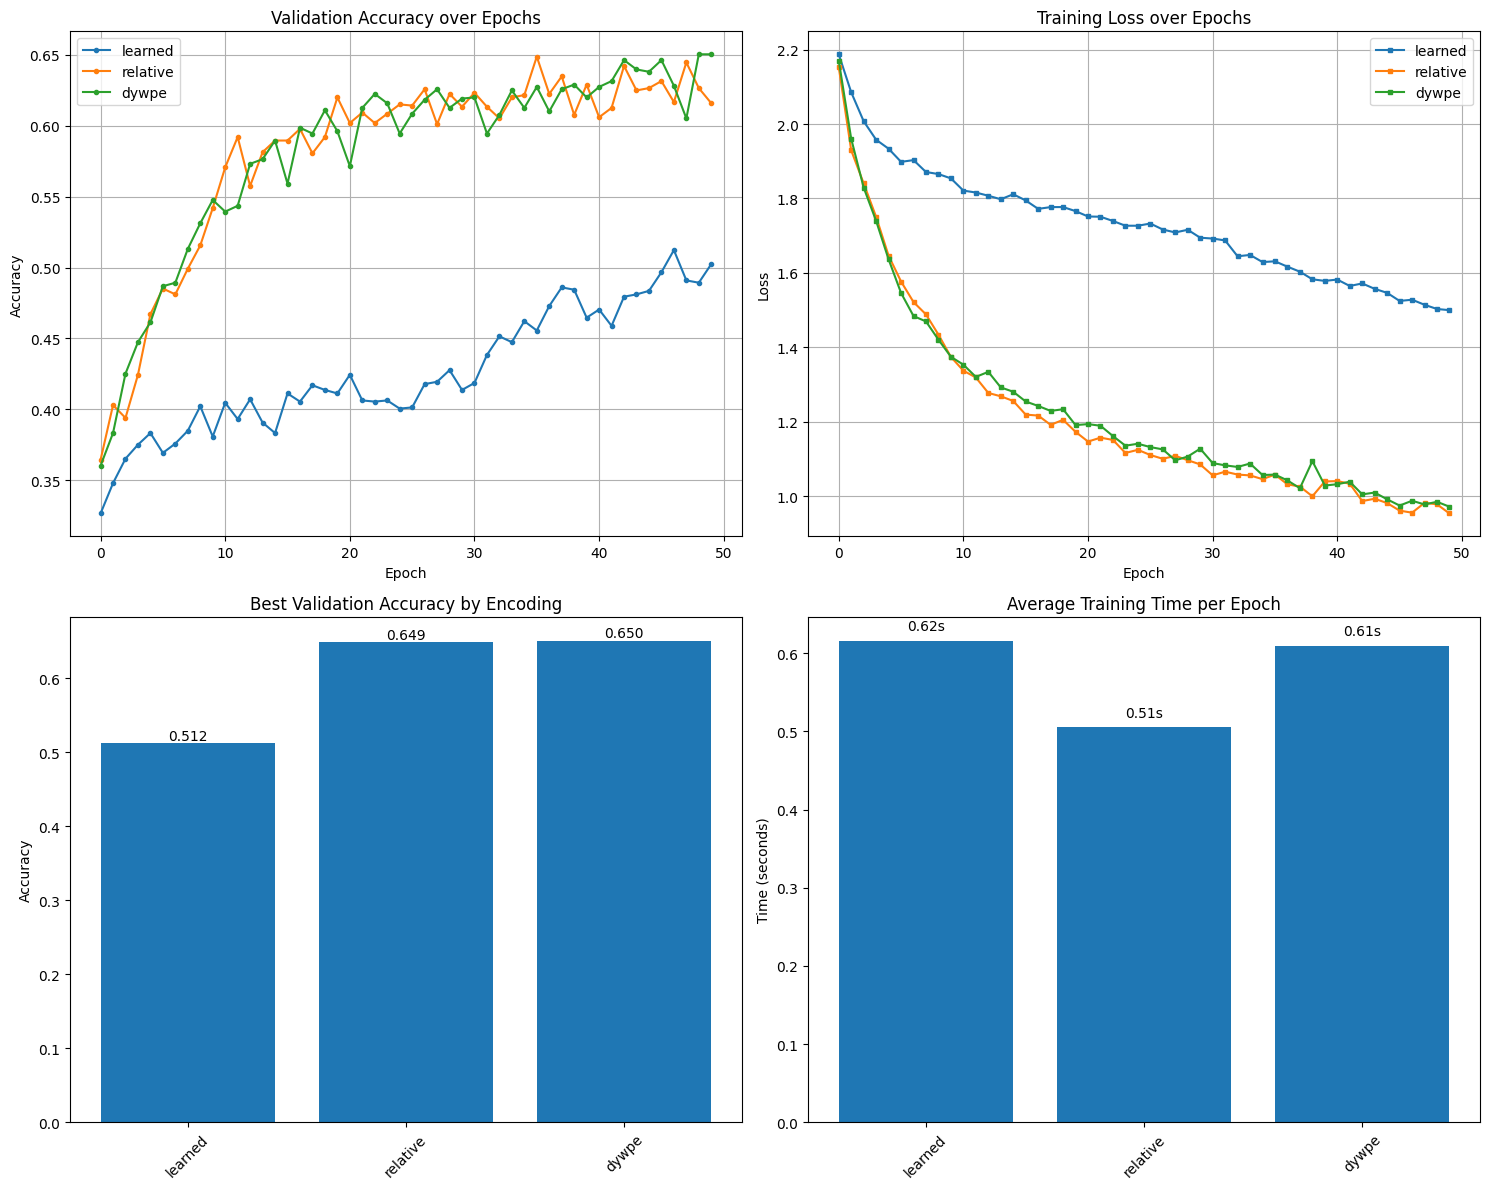

In [13]:
# Initialize benchmark
benchmark = PositionalEncodingBenchmark()

model_params = {
    'input_timesteps': 36,
    'in_channels': 6,
    'patch_size': 8,
    'embedding_dim': 32,
    'num_transformer_layers': 4,
    'num_heads': 4,
    'dim_feedforward': 128,
    'dropout': 0.2,
    'num_classes': 14
}

# Option 1: Test only your top performers from validation results
models = benchmark.run_full_benchmark(
    model_params,
    train_loader_fixed,
    valid_loader_fixed,
    test_loader_fixed,
    encodings=['learned','relative','dywpe'],
    n_epochs= 50
)

# Get comprehensive results with test performance
benchmark.print_summary()
benchmark.plot_comparison('final_results_with_test.png')

In [ ]:
benchmark = PositionalEncodingBenchmark()
models = benchmark.run_full_benchmark(
    model_params,
    train_loader_fixed,
    valid_loader_fixed,
    test_loader_fixed,
    encodings=['dywpe'],
    n_epochs=50
)

# results = run_wavelet_ablation_study(
#     dataset_name='LSST',
#     model_params=model_params,
#     train_loader=train_loader_fixed,
#     valid_loader=valid_loader_fixed,
#     test_loader=test_loader_fixed,
#     num_epochs=50,
#     quick_test=False  # Set True for 4-wavelet quick test
# )

results = run_wavelet_ablation_study(
    dataset_name='LSST',
    model_params=model_params,
    train_loader=train_loader_fixed,
    valid_loader=valid_loader_fixed,
    test_loader=test_loader_fixed,
    num_epochs=50,
    quick_test=False
)

Starting benchmark on 1 positional encodings...
Epochs per encoding: 50
Test set evaluation: ENABLED

Benchmarking: DYWPE
Epoch  2: Train Acc: 0.3709, Val Acc: 0.4030, Time: 0.60s
Epoch  4: Train Acc: 0.4223, Val Acc: 0.4128, Time: 0.63s
Epoch  6: Train Acc: 0.4437, Val Acc: 0.4679, Time: 0.61s
Epoch  8: Train Acc: 0.4601, Val Acc: 0.4959, Time: 0.60s
Epoch 10: Train Acc: 0.5045, Val Acc: 0.5066, Time: 0.59s
Epoch 12: Train Acc: 0.5300, Val Acc: 0.5329, Time: 0.59s
Epoch 14: Train Acc: 0.5354, Val Acc: 0.5428, Time: 0.60s
Epoch 16: Train Acc: 0.5448, Val Acc: 0.5584, Time: 0.81s
Epoch 18: Train Acc: 0.5436, Val Acc: 0.5617, Time: 0.61s
Epoch 20: Train Acc: 0.5744, Val Acc: 0.5748, Time: 0.62s
Epoch 22: Train Acc: 0.5720, Val Acc: 0.5938, Time: 0.61s
Epoch 24: Train Acc: 0.5855, Val Acc: 0.5987, Time: 0.61s
Epoch 26: Train Acc: 0.5892, Val Acc: 0.5822, Time: 0.60s
Epoch 28: Train Acc: 0.6016, Val Acc: 0.5970, Time: 0.83s
Epoch 30: Train Acc: 0.6155, Val Acc: 0.6069, Time: 0.73s
Epoch 32

In [ ]:
# Initialize benchmark
benchmark = PositionalEncodingBenchmark()

model_params = {
    'input_timesteps': 36,
    'in_channels': 6,
    'patch_size': 8,
    'embedding_dim': 32,
    'num_transformer_layers': 4,
    'num_heads': 4,
    'dim_feedforward': 128,
    'dropout': 0.2,
    'num_classes': 14
}

# Option 1: Test only your top performers from validation results
models = benchmark.run_full_benchmark(
    model_params,
    train_loader_fixed,
    valid_loader_fixed,
    test_loader_fixed,
    encodings=['dywpe'],
    n_epochs= 50
)

# Option 2: Or test all methods (if you have time)
# models = benchmark.run_full_benchmark(
#     model_params, train_loader, valid_loader, test_loader,
#     n_epochs=15
# )

# Get comprehensive results with test performance
# benchmark.print_summary()
# benchmark.plot_comparison('final_results_with_test.png')

# Use this:
results = run_wavelet_ablation_on_dataset(
    dataset_name='LSST',
    model_params=model_params,
    train_loader=train_loader_fixed,
    valid_loader=valid_loader_fixed,
    test_loader=test_loader_fixed,
    num_epochs=50,
    quick_test=False  # Set to True for 4-wavelet quick test
)

Starting benchmark on 1 positional encodings...
Epochs per encoding: 50
Test set evaluation: ENABLED

Benchmarking: DYWPE
Epoch  2: Train Acc: 0.3577, Val Acc: 0.4005, Time: 0.58s
Epoch  4: Train Acc: 0.4141, Val Acc: 0.4449, Time: 0.60s
Epoch  6: Train Acc: 0.4572, Val Acc: 0.5041, Time: 0.62s
Epoch  8: Train Acc: 0.5016, Val Acc: 0.5156, Time: 0.61s
Epoch 10: Train Acc: 0.5271, Val Acc: 0.5288, Time: 0.59s
Epoch 12: Train Acc: 0.5304, Val Acc: 0.5469, Time: 0.59s
Epoch 14: Train Acc: 0.5448, Val Acc: 0.5567, Time: 0.59s
Epoch 16: Train Acc: 0.5555, Val Acc: 0.5617, Time: 0.84s
Epoch 18: Train Acc: 0.5835, Val Acc: 0.5691, Time: 0.73s
Epoch 20: Train Acc: 0.5773, Val Acc: 0.5921, Time: 0.63s
Epoch 22: Train Acc: 0.5794, Val Acc: 0.6094, Time: 0.62s
Epoch 24: Train Acc: 0.6024, Val Acc: 0.5938, Time: 0.61s
Epoch 26: Train Acc: 0.5892, Val Acc: 0.6086, Time: 0.62s
Epoch 28: Train Acc: 0.6123, Val Acc: 0.5888, Time: 0.59s
Epoch 30: Train Acc: 0.6143, Val Acc: 0.6118, Time: 0.65s
Epoch 32

In [ ]:
# Initialize benchmark
benchmark = PositionalEncodingBenchmark()

model_params = {
    'input_timesteps': 36,
    'in_channels': 6,
    'patch_size': 8,
    'embedding_dim': 32,
    'num_transformer_layers': 4,
    'num_heads': 4,
    'dim_feedforward': 128,
    'dropout': 0.2,
    'num_classes': 14
}


results = run_core_ablation_studies(
    'LSST',
    model_params,
    train_loader_fixed,
    valid_loader_fixed,
    test_loader_fixed,
    num_epochs=50
)

Core DyWPE Ablation Studies on LSST
Testing the two fundamental claims of DyWPE:
1. Signal-awareness is crucial (DyWPE vs Static Wavelet PE)
2. Multi-scale decomposition is necessary (Multi-scale vs Single-scale)

Testing DyWPE (Full) (Signal-Awareness Ablation)
------------------------------------------------------------
Epoch  10: Train Acc: 0.5193, Val Acc: 0.5312, Best: 0.5312
Epoch  20: Train Acc: 0.5522, Val Acc: 0.5658, Best: 0.5757
Epoch  30: Train Acc: 0.5789, Val Acc: 0.5773, Best: 0.5929
Epoch  40: Train Acc: 0.6135, Val Acc: 0.6036, Best: 0.6209
Epoch  50: Train Acc: 0.6505, Val Acc: 0.6373, Best: 0.6398
Results: Val Acc: 0.6398, Test Acc: 0.6340, Time: 35.1s

Testing Static Wavelet PE (Signal-Awareness Ablation)
------------------------------------------------------------
Epoch  10: Train Acc: 0.4786, Val Acc: 0.5074, Best: 0.5074
Epoch  20: Train Acc: 0.5382, Val Acc: 0.5535, Best: 0.5551
Epoch  30: Train Acc: 0.5880, Val Acc: 0.5896, Best: 0.5970
Epoch  40: Train Acc: 0.